In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

# Deep learning
import tensorflow as tf
from tensorflow import keras
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1, l1_l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard,Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Input,
    BatchNormalization, Activation, SeparableConv2D, Reshape, Multiply, Add
)


from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight


# Utilities
import os
import gc
from tqdm import tqdm
import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
categories = ['Potato___Early_blight','Potato___Late_blight','Potato___healthy']

In [3]:
data = []
labels = []
path = "/kaggle/input/plant-village/PlantVillage"

for index, cat in enumerate(categories):
    cat_path = os.path.join(path, cat)
    
    print(f"category => : {cat} and size is {len(os.listdir(cat_path))} ")
    for img_name in tqdm(os.listdir(cat_path), desc=f"{cat:15}"):
        img_path = os.path.join(cat_path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # save RGB not BGR
            img = cv2.resize(img, (224, 224))           # Resize for VGG
            data.append(img)
            labels.append(index)

category => : Potato___Early_blight and size is 1000 


Potato___Early_blight: 100%|██████████| 1000/1000 [00:09<00:00, 103.13it/s]


category => : Potato___Late_blight and size is 1000 


Potato___Late_blight: 100%|██████████| 1000/1000 [00:09<00:00, 108.40it/s]


category => : Potato___healthy and size is 152 


Potato___healthy: 100%|██████████| 152/152 [00:01<00:00, 124.12it/s]


In [4]:
X = np.array(data)
y = np.array(labels)

In [5]:
X_norm = np.array(data, dtype='float32') / 255.0

In [6]:
print(X.shape)
print(y.shape)

(2152, 224, 224, 3)
(2152,)


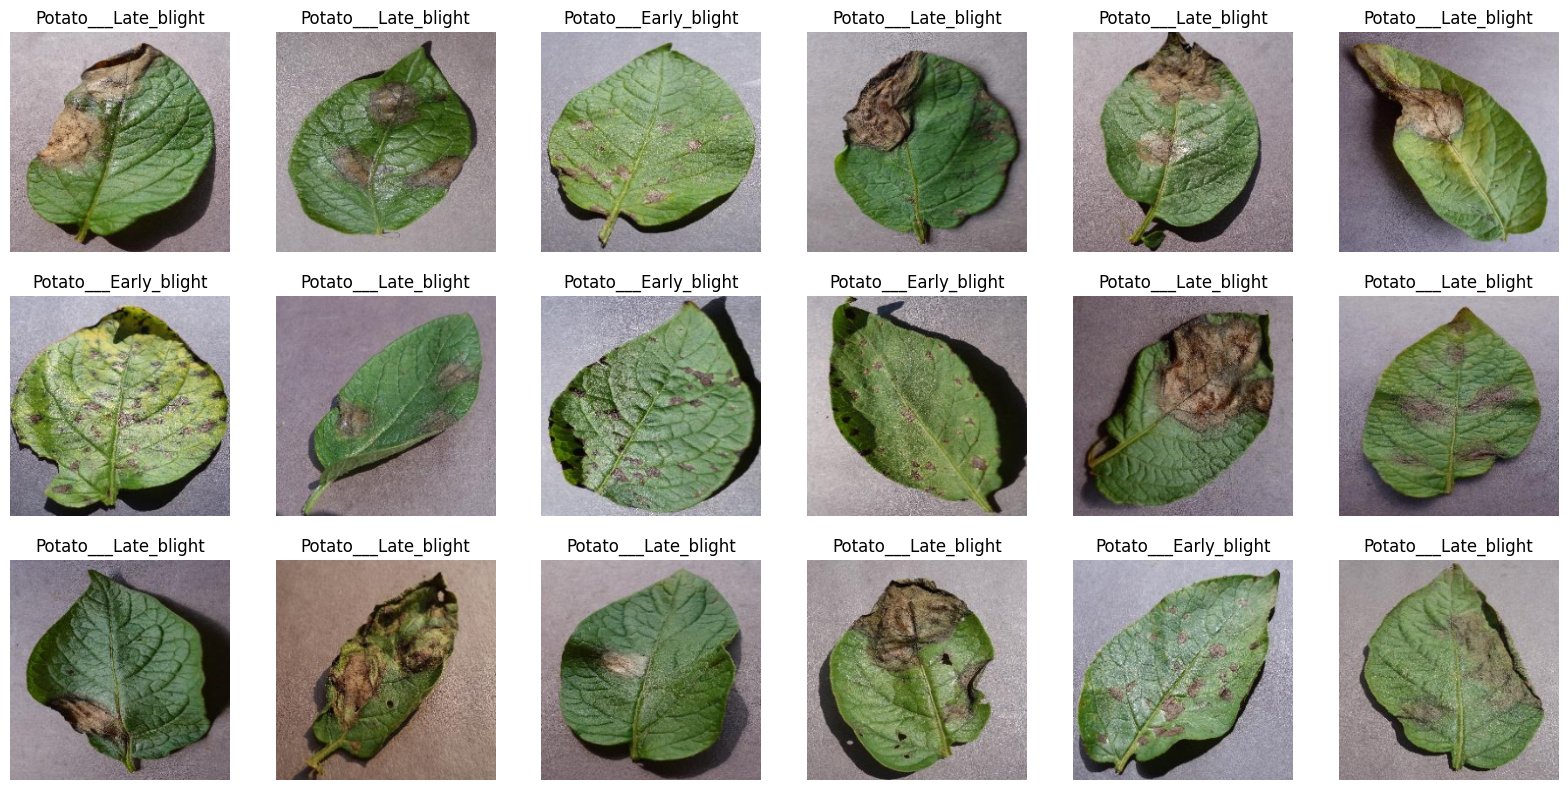

In [7]:
plt.figure(figsize=(20, 20))

for n, i in enumerate(list(np.random.randint(0, len(X_norm), 18))):
    plt.subplot(6, 6, n + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(categories[y[i]])  

## Split

In [8]:
gc.collect()
tf.keras.backend.clear_session()
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
def check_data_distribution():
    print("="*50)
    print("📊 Data Distribution Check:")
    print("="*50)
    
    # Ranges
    print(f"\nData Ranges:")
    print(f" X_train: [{X_train.min():.3f}, {X_train.max():.3f}]")
    print(f" X_test: [{X_test.min():.3f}, {X_test.max():.3f}]")
    
    # Sizes
    print(f"\nDataset Sizes:")
    print(f" Train: {len(X_train)} samples")
    print(f" Test: {len(X_test)} samples")
    
    # Class distribution
    print(f"\nClass Distribution:")
    train_classes = np.bincount(y_train)
    test_classes = np.bincount(y_test)
    
    for i in range(len(train_classes)):
        print(f"  Class {i}: Train={train_classes[i]}, Test={test_classes[i]}")
    
    # Check for imbalance
    imbalance_ratio = max(train_classes) / min(train_classes)
    if imbalance_ratio > 2:
        print(f"\nClass imbalance detected! Ratio: {imbalance_ratio:.2f}")
    else:
        print(f"\nClasses are balanced. Ratio: {imbalance_ratio:.2f}")

check_data_distribution()

📊 Data Distribution Check:

Data Ranges:
 X_train: [0.000, 1.000]
 X_test: [0.000, 1.000]

Dataset Sizes:
 Train: 1721 samples
 Test: 431 samples

Class Distribution:
  Class 0: Train=800, Test=200
  Class 1: Train=800, Test=200
  Class 2: Train=121, Test=31

Class imbalance detected! Ratio: 6.61


## convert to on hot encode

In [10]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"y_train_cat sample: {y_train_cat[0]}")

y_train_cat shape: (1721, 3)
y_train_cat sample: [1. 0. 0.]


## Calculate Class Weights

In [11]:
y_train_classes = np.argmax(y_train_cat, axis=1)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_classes),
    y=y_train_classes
)
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:")
print(f" Class 0 (Early Blight): {class_weight_dict[0]:.2f}")
print(f" Class 1 (Late Blight): {class_weight_dict[1]:.2f}")
print(f" Class 2 (Healthy): {class_weight_dict[2]:.2f}")

Class Weights:
 Class 0 (Early Blight): 0.72
 Class 1 (Late Blight): 0.72
 Class 2 (Healthy): 4.74


# Model 1 -> CNN

In [12]:
def se_block(input_tensor, reduction_ratio=16):
    """
    Squeeze-and-Excitation Block
    Adaptively recalibrates channel-wise feature responses
    """
    channels = input_tensor.shape[-1]
    
    # Squeeze: Global information embedding
    se = GlobalAveragePooling2D()(input_tensor)
    
    # Excitation: Adaptive recalibration
    se = Dense(channels // reduction_ratio, activation='relu',kernel_regularizer=l2(0.0001))(se)
    se = Dense(channels, activation='sigmoid',kernel_regularizer=l2(0.0001))(se)
    
    # Reshape for multiplication
    se = Reshape((1, 1, channels))(se)
    
    # Scale
    return Multiply()([input_tensor, se])

In [13]:
def residual_block(x, filters, kernel_size=3, stride=1, use_se=True):
    """
    Residual Block with optional SE attention
    """
    shortcut = x
    
    # First conv
    x = SeparableConv2D(
        filters, kernel_size, strides=stride, padding='same',
        depthwise_initializer='he_uniform',
        pointwise_initializer='he_uniform',
        depthwise_regularizer=l2(0.0001),
        pointwise_regularizer=l2(0.0001)
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second conv
    x = SeparableConv2D(
        filters, kernel_size, padding='same',
        depthwise_initializer='he_uniform',
        pointwise_initializer='he_uniform',
        depthwise_regularizer=l2(0.0001),
        pointwise_regularizer=l2(0.0001)
    )(x)
    x = BatchNormalization()(x)
    
    # SE block
    if use_se:
        x = se_block(x)
    
    # Adjust shortcut if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(
            filters, 1, strides=stride, padding='same',
            kernel_initializer='he_uniform',
            kernel_regularizer=l2(0.0001)
        )(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Add and activate
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x


In [14]:
def build_cnn_model(input_shape=(224, 224, 3), num_classes=3):
    """
    Build improved CNN with residual connections and SE blocks
    """
    inputs = Input(shape=input_shape)
    
    # Stem: Initial feature extraction
    x = Conv2D(32, 7, strides=2, padding='same',
               kernel_initializer='he_uniform',
               kernel_regularizer=l2(0.0001))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    # Stage 1: Low-level features
    x = residual_block(x, 64, stride=1, use_se=True)
    x = residual_block(x, 64, stride=1, use_se=True)
    x = Dropout(0.1)(x)
    
    # Stage 2: Mid-level features
    x = residual_block(x, 128, stride=2, use_se=True)
    x = residual_block(x, 128, stride=1, use_se=True)
    x = Dropout(0.15)(x)
    
    # Stage 3: High-level features
    x = residual_block(x, 256, stride=2, use_se=True)
    x = residual_block(x, 256, stride=1, use_se=True)
    x = Dropout(0.2)(x)
    
    # Stage 4: Deep features
    x = residual_block(x, 512, stride=2, use_se=True)
    x = residual_block(x, 512, stride=1, use_se=True)
    x = Dropout(0.25)(x)
    
    # Global pooling
    x = GlobalAveragePooling2D()(x)
    
    # Classification head
    x = Dense(256, kernel_initializer='he_uniform',
              kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    # Output
    outputs = Dense(num_classes, activation='softmax',
                   kernel_regularizer=l2(0.0001))(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='ImprovedCNN')
    
    return model

model_CNN = build_cnn_model()

I0000 00:00:1763326794.516010      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [15]:
model_CNN.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [16]:
model_CNN.summary()

Model: "ImprovedCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      4,736 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 56, 56,    │      2,400 │ max_pooling2d[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 56, 56,    │      4,736 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        320 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ multiply[0][0], 

 Total params: 1,673,947 (6.39 MB)

 Trainable params: 1,663,771 (6.35 MB)

 Non-trainable params: 10,176 (39.75 KB)

## Callbacks

In [17]:
# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_cnn_model_weighted.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        mode='min',
        verbose=1,
        min_delta=0.001
    ),
    
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        mode='min',
        verbose=1
    ),
    
    tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(
            f"\nEpoch {epoch+1} Summary:\n"
            f"   Train Loss: {logs['loss']:.4f} | Train Acc: {logs['accuracy']:.4f}\n"
            f"   Val Loss: {logs['val_loss']:.4f} | Val Acc: {logs['val_accuracy']:.4f}\n"
            f"   Gap: {abs(logs['accuracy'] - logs['val_accuracy']):.4f}"
        ) if epoch % 5 == 0 else None
    )
]

## Data Augementation

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode='nearest'
)

## show augmented samples

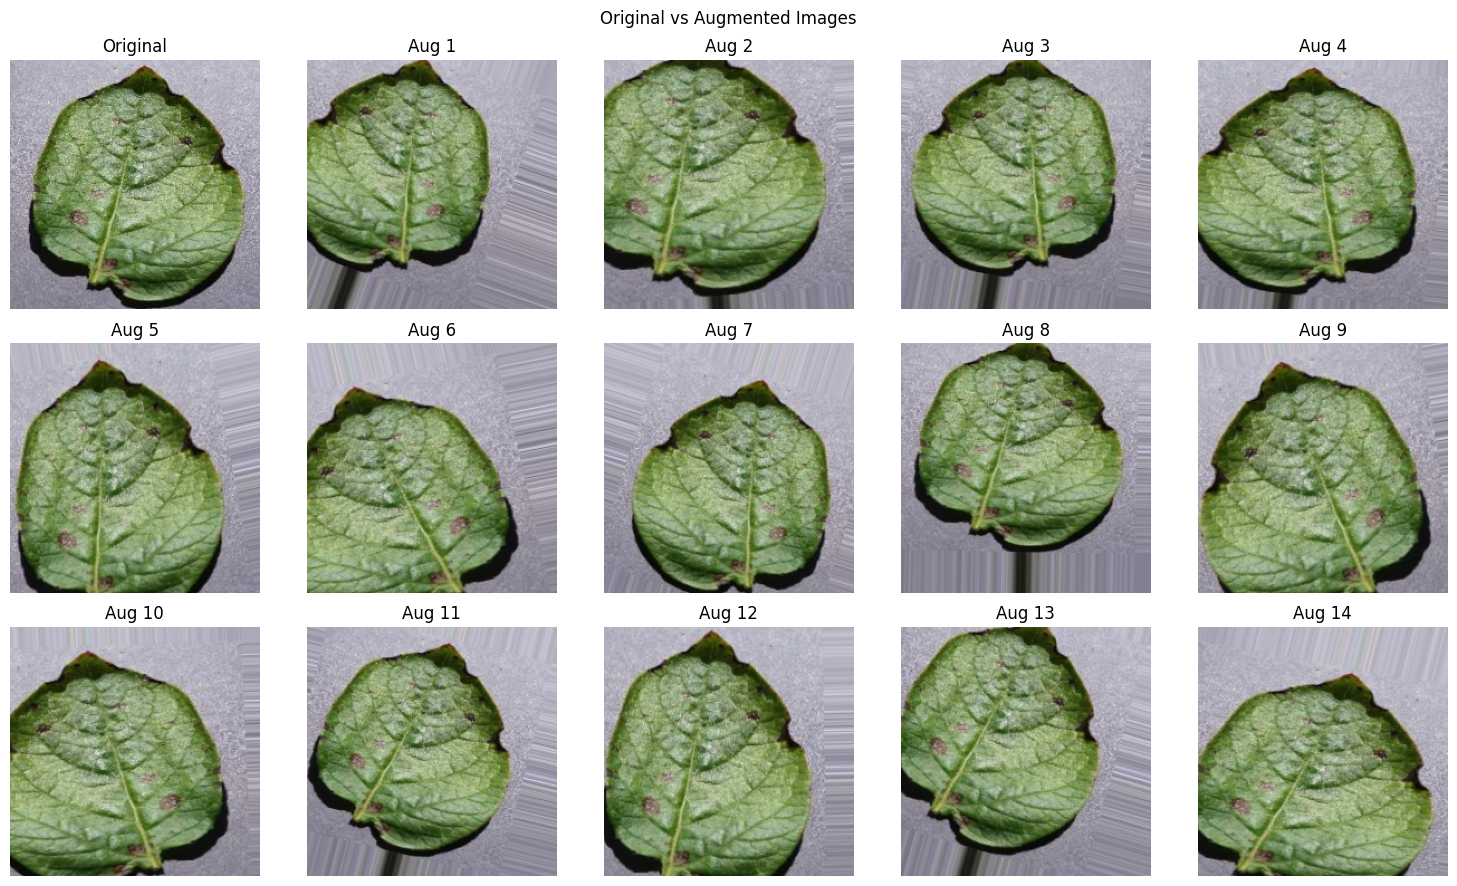

In [19]:
def show_augmented_samples(X_sample, y_sample):
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    
    img = X_sample[0:1]
    label = y_sample[0:1]
    
    axes[0, 0].imshow(img[0])
    axes[0, 0].set_title('Original')
    axes[0, 0].axis('off')
    
    for i in range(1, 15):
        row = i // 5
        col = i % 5
        
        # Generate augmented image
        aug_iter = train_datagen.flow(img, label, batch_size=1)
        aug_img = next(aug_iter)[0][0]
        
        axes[row, col].imshow(aug_img)
        axes[row, col].set_title(f'Aug {i}')
        axes[row, col].axis('off')
    
    plt.suptitle('Original vs Augmented Images')
    plt.tight_layout()
    plt.show()

show_augmented_samples(X_train, y_train)

## fit cnn modle with class weights

In [20]:
history = model_CNN.fit(
    train_datagen.flow(X_train, y_train_cat, batch_size=32, seed=42),
    validation_data=(X_test, y_test_cat),
    epochs=50,
    class_weight=class_weight_dict,
    steps_per_epoch=len(X_train) // 32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


I0000 00:00:1763326821.253132     111 service.cc:148] XLA service 0x7a00f40024f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763326821.254346     111 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763326824.606974     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/53 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.3125 - auc: 0.4918 - loss: 2.7786  

I0000 00:00:1763326843.620891     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.6974 - auc: 0.8588 - loss: 1.8669
Epoch 1: val_loss improved from inf to 2.38947, saving model to best_cnn_model_weighted.keras

Epoch 1 Summary:
   Train Loss: 1.5714 | Train Acc: 0.8011
   Val Loss: 2.3895 | Val Acc: 0.4501
   Gap: 0.3509
53/53 ━━━━━━━━━━━━━━━━━━━━ 88s 840ms/step - accuracy: 0.6993 - auc: 0.8602 - loss: 1.8615 - val_accuracy: 0.4501 - val_auc: 0.6043 - val_loss: 2.3895 - learning_rate: 0.0010
Epoch 2/50
 1/53 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9375 - auc: 0.9927 - loss: 1.1813
Epoch 2: val_loss did not improve from 2.38947
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9375 - auc: 0.9927 - loss: 1.1813 - val_accuracy: 0.4524 - val_auc: 0.6058 - val_loss: 2.4060 - learning_rate: 0.0010
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8993 - auc: 0.9825 - loss: 1.3214
Epoch 3: val_loss did not improve from 2.38947
53/53 ━━━━━━━━━━━━━━━━━━━━ 17s 313ms/step - accuracy: 0.8994 - auc

In [21]:
best_cnn_model = load_model('best_cnn_model_weighted.keras')

class_names = ['Early Blight', 'Late Blight', 'Healthy']

## 1. TEST ACCURACY


In [22]:
results = best_cnn_model.evaluate(X_test, y_test_cat, verbose=0)

if isinstance(results, list):
    test_loss = results[0]
    test_accuracy = results[1] if len(results) > 1 else results[0]
else:
    test_loss = results
    test_accuracy = results

print(f"\nTest Results:")
print(f"   • Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   • Loss: {test_loss:.4f}")


Test Results:
   • Accuracy: 0.9838 (98.38%)
   • Loss: 0.8727


## 2. PREDICTIONS

In [23]:
y_pred = best_cnn_model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1) if len(y_test_cat.shape) > 1 else y_test_cat

## 3. CONFUSION MATRIX


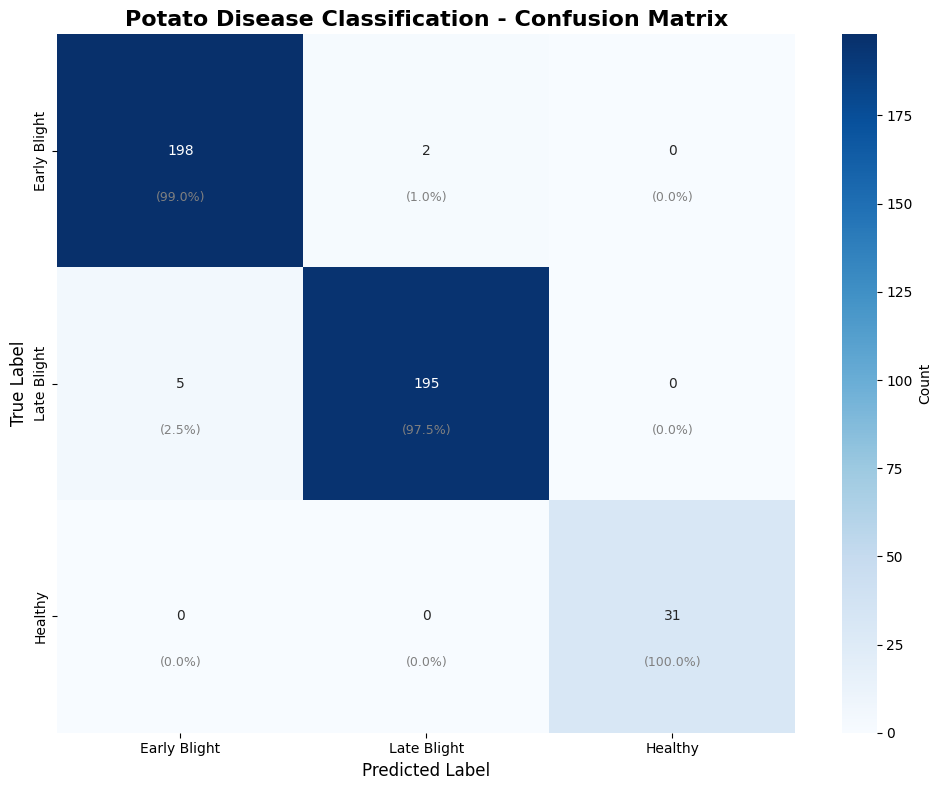

In [25]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Potato Disease Classification - Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

## 4. CLASSIFICATION REPORT


In [26]:
print("\n" + "=" * 60)
print("DETAILED PERFORMANCE REPORT")
print("=" * 60)

report = classification_report(y_true_classes, y_pred_classes, 
                              target_names=class_names,
                              output_dict=True)

for class_name in class_names:
    print(f"\n {class_name}:")
    print(f"   • Precision: {report[class_name]['precision']:.3f}")
    print(f"   • Recall: {report[class_name]['recall']:.3f}")
    print(f"   • F1-Score: {report[class_name]['f1-score']:.3f}")
    print(f"   • Samples: {int(report[class_name]['support'])}")

print(f"\n Overall Performance:")
print(f"   • Accuracy: {report['accuracy']:.3f}")
print(f"   • Average F1-Score: {report['macro avg']['f1-score']:.3f}")


DETAILED PERFORMANCE REPORT

 Early Blight:
   • Precision: 0.975
   • Recall: 0.990
   • F1-Score: 0.983
   • Samples: 200

 Late Blight:
   • Precision: 0.990
   • Recall: 0.975
   • F1-Score: 0.982
   • Samples: 200

 Healthy:
   • Precision: 1.000
   • Recall: 1.000
   • F1-Score: 1.000
   • Samples: 31

 Overall Performance:
   • Accuracy: 0.984
   • Average F1-Score: 0.988


## 5. PERFORMANCE VISUALIZATION


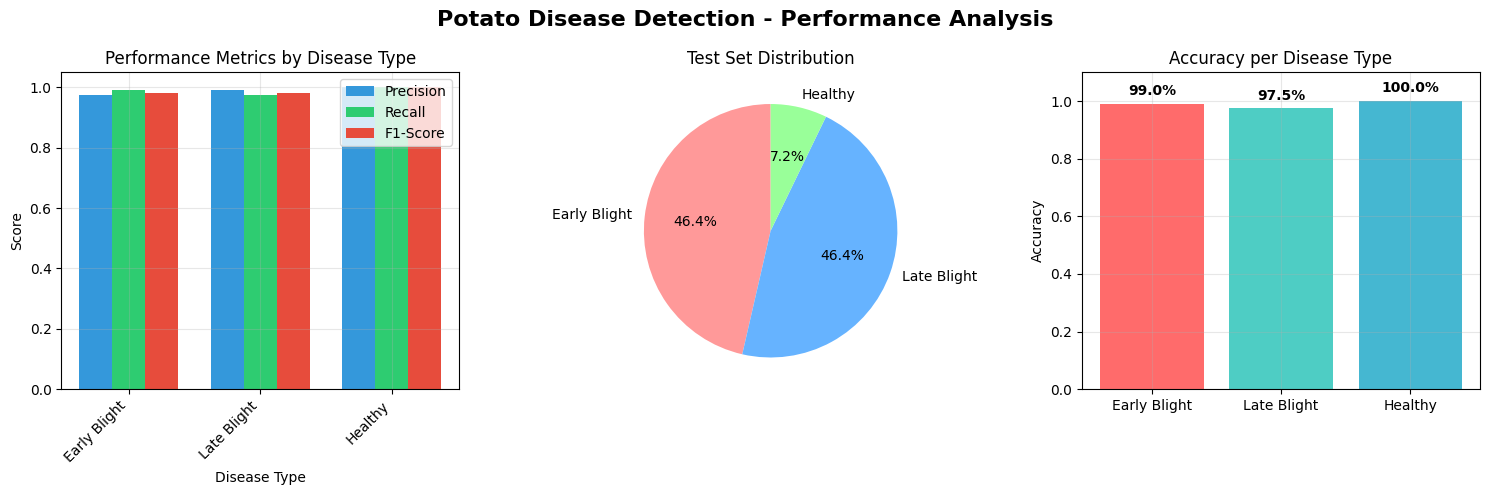

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Chart 1: Class-wise Metrics
ax1 = axes[0]
metrics = ['Precision', 'Recall', 'F1-Score']
x = np.arange(len(class_names))
width = 0.25

precision = [report[cn]['precision'] for cn in class_names]
recall = [report[cn]['recall'] for cn in class_names]
f1_score = [report[cn]['f1-score'] for cn in class_names]

ax1.bar(x - width, precision, width, label='Precision', color='#3498db')
ax1.bar(x, recall, width, label='Recall', color='#2ecc71')
ax1.bar(x + width, f1_score, width, label='F1-Score', color='#e74c3c')

ax1.set_xlabel('Disease Type')
ax1.set_ylabel('Score')
ax1.set_title('Performance Metrics by Disease Type')
ax1.set_xticks(x)
ax1.set_xticklabels(class_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Chart 2: Sample Distribution
ax2 = axes[1]
support = [report[cn]['support'] for cn in class_names]
colors = ['#ff9999', '#66b3ff', '#99ff99']
wedges, texts, autotexts = ax2.pie(support, labels=class_names, autopct='%1.1f%%',
                                    colors=colors, startangle=90)
ax2.set_title('Test Set Distribution')

# Chart 3: Accuracy per Class
ax3 = axes[2]
class_accuracy = []
for i in range(len(class_names)):
    if cm[i].sum() > 0:
        acc = cm[i, i] / cm[i].sum()
        class_accuracy.append(acc)
    else:
        class_accuracy.append(0)

bars = ax3.bar(class_names, class_accuracy, color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
ax3.set_title('Accuracy per Disease Type')
ax3.set_ylabel('Accuracy')
ax3.set_ylim([0, 1.1])
ax3.grid(True, alpha=0.3)

# Add percentage labels
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Potato Disease Detection - Performance Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


## 6. ERROR ANALYSIS


In [28]:
print("\n" + "=" * 60)
print("ERROR ANALYSIS")
print("=" * 60)

total_samples = len(y_true_classes)
correct_predictions = np.sum(y_pred_classes == y_true_classes)
wrong_predictions = total_samples - correct_predictions

print(f"\n Correct Predictions: {correct_predictions}/{total_samples} ({correct_predictions/total_samples*100:.1f}%)")
print(f"Wrong Predictions: {wrong_predictions}/{total_samples} ({wrong_predictions/total_samples*100:.1f}%)")

print("\nCommon Misclassifications:")
for i, true_class in enumerate(class_names):
    for j, pred_class in enumerate(class_names):
        if i != j and cm[i, j] > 0:
            print(f"   • {true_class} → {pred_class}: {cm[i, j]} times")


ERROR ANALYSIS

 Correct Predictions: 424/431 (98.4%)
Wrong Predictions: 7/431 (1.6%)

Common Misclassifications:
   • Early Blight → Late Blight: 2 times
   • Late Blight → Early Blight: 5 times


## 7. FINAL SUMMARY

In [30]:
print("\n" + "=" * 60)
print("FINAL SUMMARY")
print("=" * 60)

f1_scores = [report[cn]['f1-score'] for cn in class_names]
best_class = class_names[np.argmax(f1_scores)]
worst_class = class_names[np.argmin(f1_scores)]

print(f"\n Potato Disease Detection Model:")
print(f"   • Overall Accuracy: {test_accuracy*100:.2f}%")
print(f"   • Best Detection: {best_class} (F1: {max(f1_scores):.3f})")
print(f"   • Needs Improvement: {worst_class} (F1: {min(f1_scores):.3f})")


print("\n" + "=" * 60)
print("Evaluation Complete!")
print("=" * 60)

import json

results_summary = {
    'model': 'Potato Disease Classification',
    'categories': categories,
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'per_class_accuracy': {cn: float(acc) for cn, acc in zip(class_names, class_accuracy)},
    'f1_scores': {cn: float(f1) for cn, f1 in zip(class_names, f1_scores)},
    'total_samples': int(total_samples),
    'correct_predictions': int(correct_predictions)
}

with open('potato_model_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print("\nResults saved to 'potato_model_results.json'")


FINAL SUMMARY

 Potato Disease Detection Model:
   • Overall Accuracy: 98.38%
   • Best Detection: Healthy (F1: 1.000)
   • Needs Improvement: Late Blight (F1: 0.982)

Evaluation Complete!

Results saved to 'potato_model_results.json'


# Model 2 -> InceptionV3

In [32]:
tf.keras.backend.clear_session()

In [33]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'   # use pretrained on imagenet
)

base_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## Add custom layers


In [34]:
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(3, activation='softmax')(x)

## Create the model

In [35]:
model_inception = Model(inputs, outputs)

## Compile with low learning rate


In [36]:
print(f"Total layers: {len(model_inception.layers)}")
print(f"Trainable parameters: {model_inception.count_params():,}")

Total layers: 8
Trainable parameters: 22,360,611


In [38]:
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

In [39]:
model_inception.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [40]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_inceptionV3.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        mode='min',
        verbose=1,
        min_delta=0.001
    ),
    
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        mode='min',
        verbose=1
    ),
    
    tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: print(
            f"\nEpoch {epoch+1} Summary:\n"
            f"   Train Loss: {logs['loss']:.4f} | Train Acc: {logs['accuracy']:.4f}\n"
            f"   Val Loss: {logs['val_loss']:.4f} | Val Acc: {logs['val_accuracy']:.4f}\n"
            f"   Gap: {abs(logs['accuracy'] - logs['val_accuracy']):.4f}"
        ) if epoch % 5 == 0 else None
    )
]

In [41]:
model_inception_history = model_inception.fit(
    train_datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_test, y_test_cat),
    epochs=40,
    class_weight=class_weight_dict,
    steps_per_epoch=len(X_train) // 32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.4993 - auc: 0.6831 - loss: 0.9380
Epoch 1: val_loss improved from inf to 0.21937, saving model to best_inceptionV3.keras

Epoch 1 Summary:
   Train Loss: 0.6981 | Train Acc: 0.6454
   Val Loss: 0.2194 | Val Acc: 0.9211
   Gap: 0.2758
53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 864ms/step - accuracy: 0.5020 - auc: 0.6860 - loss: 0.9336 - val_accuracy: 0.9211 - val_auc: 0.9869 - val_loss: 0.2194 - learning_rate: 1.0000e-04
Epoch 2/40
 1/53 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.9062 - auc: 0.9702 - loss: 0.2772
Epoch 2: val_loss did not improve from 0.21937
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9062 - auc: 0.9702 - loss: 0.2772 - val_accuracy: 0.9211 - val_auc: 0.9869 - val_loss: 0.2195 - learning_rate: 1.0000e-04
Epoch 3/40
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8828 - auc: 0.9677 - loss: 0.3336
Epoch 3: val_loss improved from 0.21937 to 0.14452, saving model to best_inceptionV3.keras
53/53 ━━━

## CONFUSION MATRIX 

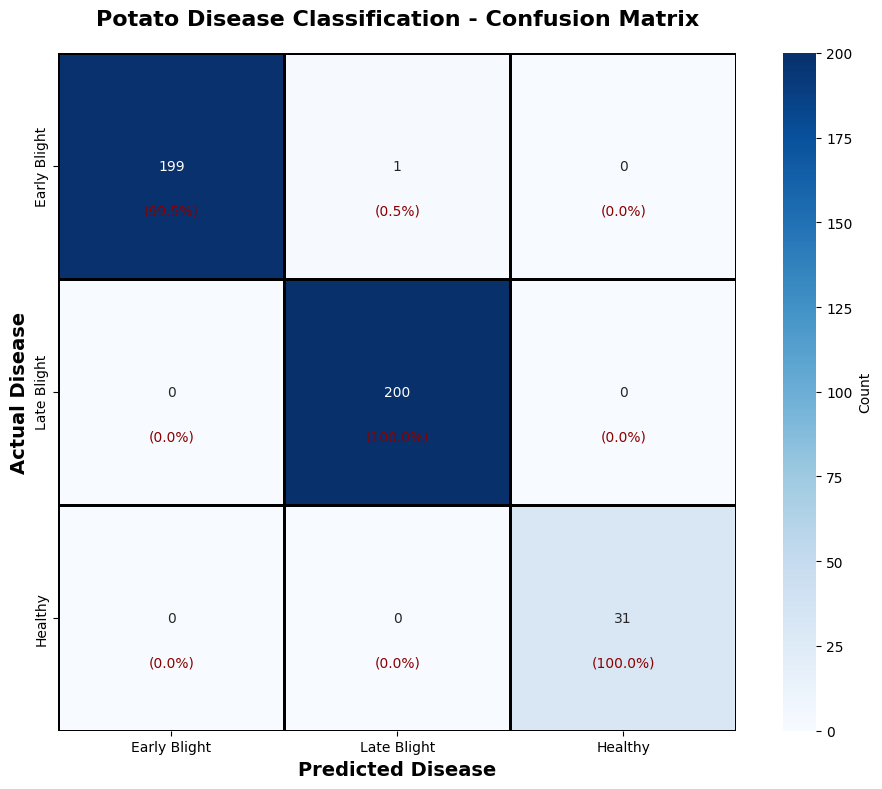

In [42]:
plt.figure(figsize=(10, 8))

inception_model = load_model('best_inceptionV3.keras')

y_pred = inception_model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1) if len(y_test_cat.shape) > 1 else y_test_cat

cm = confusion_matrix(y_true_classes, y_pred_classes)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            square=True, linewidths=1, linecolor='black',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})

plt.title('Potato Disease Classification - Confusion Matrix', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Actual Disease', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Disease', fontsize=14, fontweight='bold')

for i in range(len(class_names)):
    for j in range(len(class_names)):
        percentage = (cm[i, j] / cm[i].sum()) * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='darkred')

plt.tight_layout()
plt.show()

## PRINT RESULTS


In [43]:
print("=" * 60)
print("CONFUSION MATRIX RESULTS")
print("=" * 60)

print("\nAccuracy per Disease:")
print("-" * 40)
for i, disease in enumerate(class_names):
    total = cm[i].sum()
    correct = cm[i, i]
    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"{disease:15} → {correct}/{total} correct ({accuracy:.1f}%)")

print("\nCommon Mistakes:")
print("-" * 40)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            percentage = (cm[i, j] / cm[i].sum()) * 100
            print(f"• {class_names[i]} misclassified as {class_names[j]}: {cm[i, j]} times ({percentage:.1f}%)")

total_correct = np.diag(cm).sum()
total_samples = cm.sum()
overall_accuracy = (total_correct / total_samples) * 100

print("\n" + "=" * 60)
print(f"Overall Accuracy: {total_correct}/{total_samples} ({overall_accuracy:.2f}%)")
print("=" * 60)

CONFUSION MATRIX RESULTS

Accuracy per Disease:
----------------------------------------
Early Blight    → 199/200 correct (99.5%)
Late Blight     → 200/200 correct (100.0%)
Healthy         → 31/31 correct (100.0%)

Common Mistakes:
----------------------------------------
• Early Blight misclassified as Late Blight: 1 times (0.5%)

Overall Accuracy: 430/431 (99.77%)


# Model Performance

## 1. ACCURACY & LOSS CURVES

 INCEPTION MODEL - TRAINING RESULTS


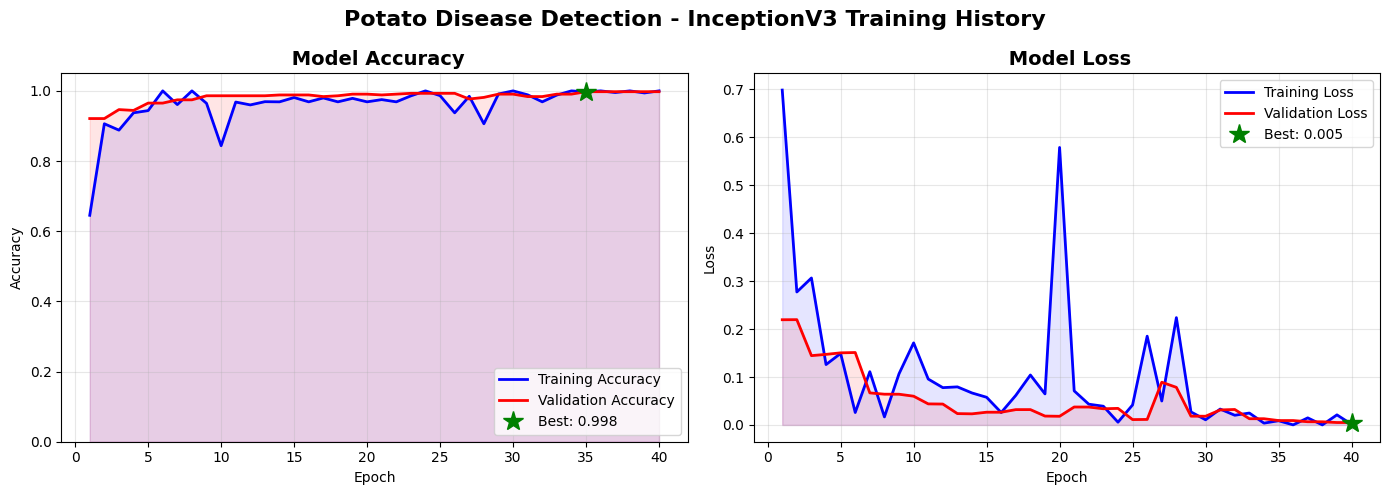

In [44]:
print("=" * 60)
print(" INCEPTION MODEL - TRAINING RESULTS")
print("=" * 60)

history = model_inception_history.history
epochs = range(1, len(history['loss']) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Plot
ax1.plot(epochs, history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
ax1.plot(epochs, history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
ax1.fill_between(epochs, history['accuracy'], alpha=0.1, color='blue')
ax1.fill_between(epochs, history['val_accuracy'], alpha=0.1, color='red')
ax1.set_title(' Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.05])

# Add best accuracy point
best_val_acc = max(history['val_accuracy'])
best_epoch = history['val_accuracy'].index(best_val_acc) + 1
ax1.plot(best_epoch, best_val_acc, 'g*', markersize=15, label=f'Best: {best_val_acc:.3f}')
ax1.legend(loc='lower right')

# Loss Plot
ax2.plot(epochs, history['loss'], 'b-', label='Training Loss', linewidth=2)
ax2.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax2.fill_between(epochs, history['loss'], alpha=0.1, color='blue')
ax2.fill_between(epochs, history['val_loss'], alpha=0.1, color='red')
ax2.set_title(' Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Add best loss point
best_val_loss = min(history['val_loss'])
best_loss_epoch = history['val_loss'].index(best_val_loss) + 1
ax2.plot(best_loss_epoch, best_val_loss, 'g*', markersize=15, label=f'Best: {best_val_loss:.3f}')
ax2.legend(loc='upper right')

plt.suptitle('Potato Disease Detection - InceptionV3 Training History', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. TRAINING SUMMARY


In [45]:
print("\n Training Summary:")
print("-" * 40)
print(f"Total Epochs: {len(epochs)}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_loss_epoch})")
print(f"Final Training Accuracy: {history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")


 Training Summary:
----------------------------------------
Total Epochs: 40
Best Validation Accuracy: 0.9977 (Epoch 35)
Best Validation Loss: 0.0051 (Epoch 40)
Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9977
Final Training Loss: 0.0015
Final Validation Loss: 0.0051


## 3. OVERFITTING CHECK


In [46]:
print("\nModel Analysis:")
print("-" * 40)

# Check for overfitting
final_train_acc = history['accuracy'][-1]
final_val_acc = history['val_accuracy'][-1]
acc_diff = final_train_acc - final_val_acc
print(f"Gap between training and validation: {acc_diff:.3f}")


Model Analysis:
----------------------------------------
Gap between training and validation: 0.002


## 4. IMPROVEMENT ANALYSIS


In [47]:
# Calculate improvement
initial_acc = history['val_accuracy'][0]
improvement = best_val_acc - initial_acc
improvement_percentage = (improvement / initial_acc) * 100

print(f"\nPerformance Improvement:")
print(f"   • Initial Accuracy: {initial_acc:.4f}")
print(f"   • Best Accuracy: {best_val_acc:.4f}")
print(f"   • Improvement: {improvement:.4f} ({improvement_percentage:.1f}%)")


Performance Improvement:
   • Initial Accuracy: 0.9211
   • Best Accuracy: 0.9977
   • Improvement: 0.0766 (8.3%)


## 5. SIMPLE METRICS BAR CHART


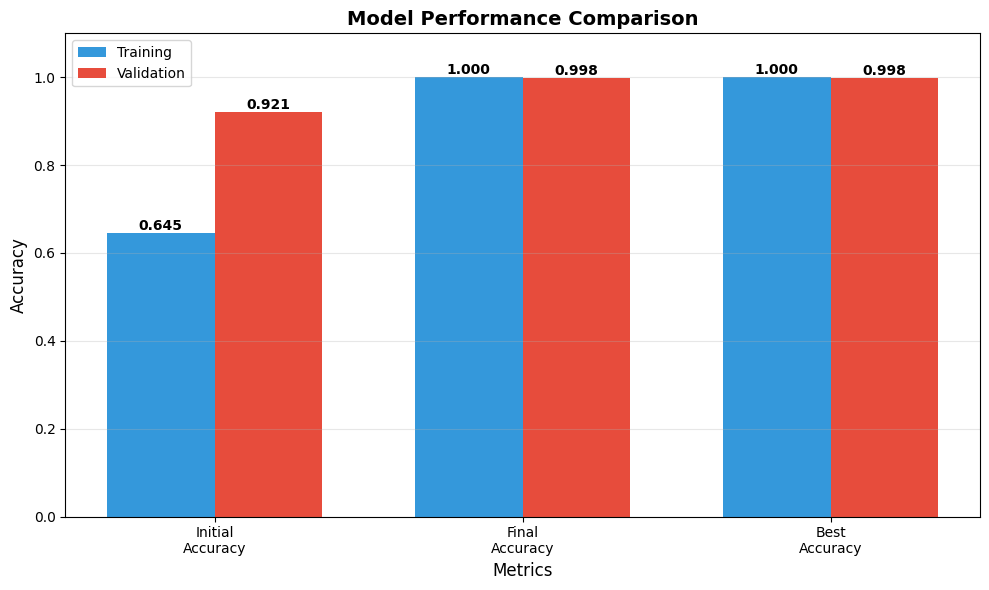

In [48]:
plt.figure(figsize=(10, 6))

metrics = ['Initial\nAccuracy', 'Final\nAccuracy', 'Best\nAccuracy']
train_values = [history['accuracy'][0], history['accuracy'][-1], max(history['accuracy'])]
val_values = [history['val_accuracy'][0], history['val_accuracy'][-1], best_val_acc]

x = np.arange(len(metrics))
width = 0.35

bars1 = plt.bar(x - width/2, train_values, width, label='Training', color='#3498db')
bars2 = plt.bar(x + width/2, val_values, width, label='Validation', color='#e74c3c')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([0, 1.1])

plt.tight_layout()
plt.show()


## 6. SAVE TRAINING HISTORY

In [50]:

training_summary = {
    'model': 'InceptionV3 - Potato Disease Detection',
    'total_epochs': len(epochs),
    'best_validation_accuracy': float(best_val_acc),
    'best_epoch': int(best_epoch),
    'final_training_accuracy': float(history['accuracy'][-1]),
    'final_validation_accuracy': float(history['val_accuracy'][-1]),
    'improvement': float(improvement),
    'improvement_percentage': float(improvement_percentage)
}

with open('inception_training_history.json', 'w') as f:
    json.dump(training_summary, f, indent=4)

print("\nTraining history saved to 'inception_training_history.json'")


Training history saved to 'inception_training_history.json'


In [ ]:
inception_model.save('inceptionV3_model.h5', save_format='h5')
model_CNN.save('cnn_model.h5', save_format='h5')

In [55]:
import pickle
import keras

with open('Inception_Model.pkl', 'wb') as f:
    pickle.dump(inception_model, f)
    
with open('CNN_Model.pkl', 'wb') as f:
    pickle.dump(model_CNN, f)
    
print("✅ Saved as pickle files")

✅ Saved as pickle files


In [58]:
print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")


TensorFlow: 2.18.0
Keras: 3.8.0
